# Conclusion:
The stock market is really hard to predict.  I think I'll just stick with investing long-term in UPRO

0.6


In [ ]:
# Define getting next batch of stock data

In [8]:
# ---------------Load Data-----------------
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as random
import os as os
%matplotlib inline 


# data = pd.read_csv('data/training.csv')
print('libraries imported!')
stockFiles = os.listdir('stockData')
predictionsCount = 3 #the High, Low, and close over the course of the prediction period
setupArrayLength = 250 # this should be the numDays you want in a setup x 5 

def getStockData(fileName, start, setupLength, predictLength):
    setupData = []
    file = open('stockData/' + fileName)
    fLines = file.readlines()
    end = start + setupLength + predictLength -1
    predictStartDate = fLines[start + predictLength -1].split(',')[0]
    predictEndDate = fLines[start].split(',')[0]
    high = 0
    low = 1000000
    
    # get the 'old' stock data
    for i in range(end, start-1, -1):
        line = fLines[i].strip()
        lineArray = line.split(',')
        for k in range(1,7):
            lineArray[k] = float(lineArray[k])
        x = lineArray[6]/lineArray[4]

        if(i>=(start+predictLength)):
            for j in range(1,5):
                setupData.append(lineArray[j]*x)
            setupData.append(lineArray[5])

    
    # get the high/low of 'new' stock data (we try and predict this)
        if(i<(start + predictLength)):
            if (lineArray[2]*x > high):
                high = lineArray[2]*x
            if (lineArray[3]*x < low):
                low = lineArray[3]*x
                
        close = float(fLines[start].split(',')[4])*x
    
    file.close()
    
    
    # ----------------------convert data to 0=>1 instead of prices
    tmpHi = 0
    tmpLow = 1000000
    tmpVolHi = 1
    tmpVolLow = 1000000000
    
    for i in range(0,len(setupData)): # find the His and Lows for vol and price
        if(5*(i//5)+1 == i):
            if(setupData[i] >= tmpHi):
                tmpHi = setupData[i]
        if(5*(i//5)+2 == i):
            if(setupData[i] < tmpLow):
                tmpLow = setupData[i]
        if(5*(i//5)+4 == i):
            if(setupData[i] >= tmpVolHi):
                tmpVolHi = setupData[i]
            if(setupData[i] < tmpVolLow):
                tmpVolLow = setupData[i]
    
    for i in range(0,len(setupData)): # convert the data to values between 0 and 1
        if(5*(i//5)+4 != i):
            if(tmpHi - tmpLow == 0):
                tmpLow = 0
            setupData[i] = (setupData[i] - tmpLow)/(tmpHi-tmpLow)
        if(5*(i//5)+4 == i):
            setupData[i] = (setupData[i] - tmpVolLow)/(tmpVolHi-tmpVolLow)
        
    if(high > 100):
        high=low=close = 30
    targets = [high/5,low/5,close/5]
    symbolAndPredictDates = [fileName.split('.')[0], predictStartDate, predictEndDate]
    
#   get only the close price
    justCloseData = []
    for i in range(0,len(setupData)):
        if(5*(i//5)+3==i):
            justCloseData.append(setupData[i])
    return justCloseData, targets, symbolAndPredictDates
 


def getBatch(setupLength, predictLength):
    randIndex = random.randint(0,950)
    fileName = stockFiles[randIndex]
    file = open('stockData/' + fileName)
    fLines = file.readlines()
    file.close()
    start = random.randint(1, (len(fLines) - setupLength - predictLength - 1))
    spySetupData, spyLabels, labelDates = getStockData('SPY.txt',start,setupLength,predictLength)
    stockSetupData, stockTargets, labelDates = getStockData(fileName,start,setupLength,predictLength)
    setupData = [[]]
    
    stockSetupData = np.asarray(stockSetupData,dtype=np.float32)
#     stockSetupData = np.reshape(stockSetupData,setupLength,1)
    setupData[0].append(stockSetupData)
#     setupData.append(spySetupData)
    setupData = np.reshape(setupData,(1,setupLength,1))
    
    return setupData, np.asarray(stockTargets,dtype=np.float32), labelDates
    
print(getBatch(10,1))
print('get Data methods defined')

libraries imported!
(array([[[ 0.44239593],
        [ 0.85253417],
        [ 0.75115293],
        [ 0.93087649],
        [ 0.80645239],
        [ 0.65898645],
        [ 0.61751211],
        [ 0.62211949],
        [ 0.69585246],
        [ 0.62672883]]], dtype=float32), array([ 4.19063902,  4.0887475 ,  4.12707376], dtype=float32), ['TJX', '2010-10-07', '2010-10-07'])
get Data methods defined


In [ ]:
# define and run our RNN

In [9]:
with tf.variable_scope("greg", reuse=True) as scope:
    setUpDaysCount = 10
    data = tf.placeholder(tf.float32, [None, setUpDaysCount,1]) #Number of examples, number of input, dimension of each input
    target = tf.placeholder(tf.float32, [3])
    num_hidden = 10
    cell1 = tf.nn.rnn_cell.LSTMCell(num_hidden, state_is_tuple=True)
    cell2 = tf.nn.rnn_cell.LSTMCell(num_hidden, state_is_tuple=True)
    cells=[]
    cells.append(cell1)
    cells.append(cell2)
    stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True) # using multiple LSTM layers
    
    
    
    val, _ = tf.nn.dynamic_rnn(stacked_lstm, data, dtype=tf.float32)
    last = val[0,setUpDaysCount-1:setUpDaysCount,:] # this is the last 'slice' of the values from our neuralNet
    
    # add a readout layer to sum the results of the NN
    weight = tf.Variable(tf.truncated_normal([num_hidden,1]))
    bias = tf.Variable(tf.constant(0.1, shape=[1]))
    predictionLayer = tf.matmul(last, weight) + bias
    prediction = predictionLayer[0,:]
    
    # no classes used, just minimize the difference between actual and predicted
    loss = ((tf.abs(target[2]-prediction))/1)*1
    optimizer = tf.train.AdamOptimizer(1)
    train_step = optimizer.minimize(loss)
    

    # set up our session and train away!
    init_op = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init_op)

    lossArray = []     # storing values in to arrays so we can display in graphs
    predictArray = []
    targetArray = []
    for i in range(0,100000):
        inp = getBatch(setUpDaysCount,1)
        sess.run(train_step,{data:inp[0],target:inp[1]})
        if(i%2==0):
            predict = sess.run(prediction,{data:inp[0],target:inp[1]})
            goal = sess.run(target[0],{data:inp[0],target:inp[1]})
            delta = sess.run(loss,{data:inp[0],target:inp[1]})
            lossArray.append(delta)
            predictArray.append(predict)
            targetArray.append(goal)
        if(i%100 ==0):
            delta = sess.run(loss,{data:inp[0],target:inp[1]})
            print('delta at trial ' +str(i)+': ' + str(delta))
            
    
    sess.close()

delta at trial 0: [ 3.08533859]
delta at trial 100: [ 1.5372088]
delta at trial 200: [ 2.3306675]
delta at trial 300: [ 0.13606977]
delta at trial 400: [ 3.38891983]
delta at trial 500: [ 3.23867178]
delta at trial 600: [ 3.75966096]
delta at trial 700: [ 1.45440698]
delta at trial 800: [ 9.46151924]
delta at trial 900: [ 4.25265074]
delta at trial 1000: [ 0.12800026]
delta at trial 1100: [ 0.30125797]
delta at trial 1200: [ 2.28522778]
delta at trial 1300: [ 5.03141022]
delta at trial 1400: [ 7.61101198]
delta at trial 1500: [ 1.91058588]
delta at trial 1600: [ 2.2575469]
delta at trial 1700: [ 6.46775389]
delta at trial 1800: [ 2.07735538]
delta at trial 1900: [ 2.81039381]
delta at trial 2000: [ 0.88138819]
delta at trial 2100: [ 4.99351501]
delta at trial 2200: [ 5.97657633]
delta at trial 2300: [ 5.05292225]
delta at trial 2400: [ 2.09061146]
delta at trial 2500: [ 4.49542189]
delta at trial 2600: [ 1.46054626]
delta at trial 2700: [ 1.25476527]
delta at trial 2800: [ 0.2159059]
d

KeyboardInterrupt: 

[ 2.25838089]
Average delta between prediction and actual: 3.66372


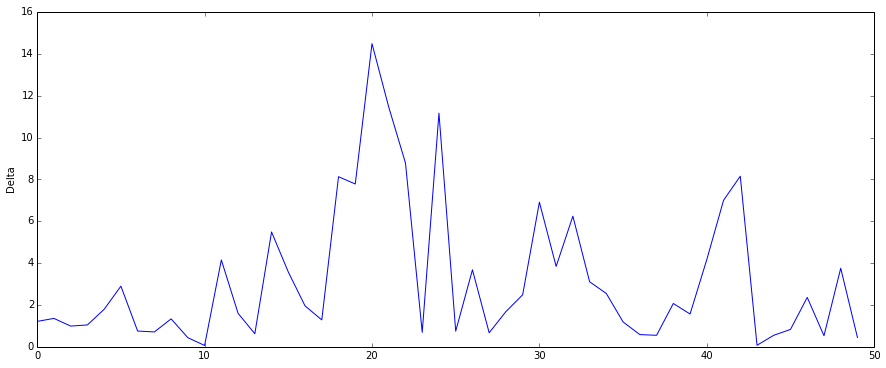

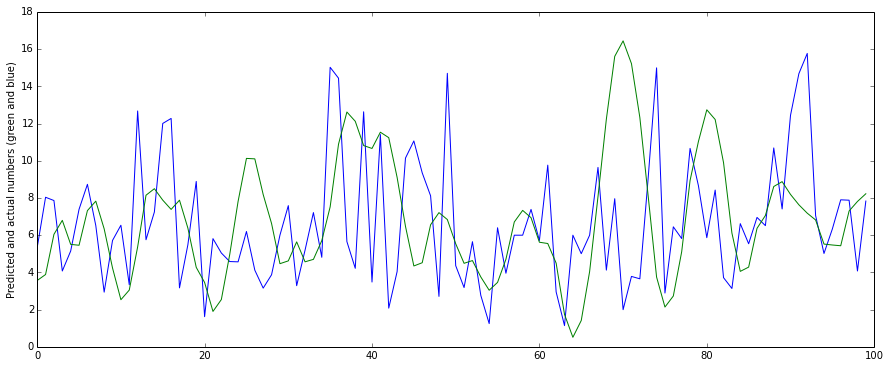

In [17]:
print(lossArray[234])
print('Average delta between prediction and actual: ' + str(np.mean(lossArray[2500:])))
plt.rcParams['figure.figsize'] = (15, 6)
plt.plot(lossArray[len(lossArray)-50:len(lossArray)])
plt.ylabel('Delta')
plt.show()

plt.ylabel('Predicted and actual numbers (green and blue)')
plt.plot(targetArray[len(targetArray)-100:len(targetArray)])
plt.plot(predictArray[len(predictArray)-100:len(predictArray)])